# Pdfmatcher
### by Robin

# Challenge
<img src="img/pdf-file-format-symbol.png" alt="Drawing" style="width: 50px;"/>

### -help annotaters by clustering similar pdfs
### -identify duplicates

# Approach

## - Text clustering
## - Layout mapping
## - Image analysis


# Text clustering

In [1]:
import glob
import pandas as pd
import os

In [2]:
filelist = glob.glob("data/*.tsv")
print(filelist)
df = pd.read_csv('data/in.tsv',header=None,sep="\t")
labels = pd.read_csv('data/expected-original.tsv',header=None,sep="\t")

['data/expected-original.tsv', 'data/in.tsv', 'data/test.tsv']


In [3]:
labels

,0
0,address__post_town=OLDHAM address__postcode=OL...
1,address__post_town=GAINSBOROUGH address__postc...
2,address__post_town=STAINES-UPON-THAMES[11] add...
3,address__post_town=LONDON address__postcode=W1...
4,address__post_town=NOTTINGHAM address__postcod...
...,...
1724,address__post_town=OLDHAM address__postcode=OL...
1725,address__post_town=BROADWAY address__postcode=...
1726,address__post_town=LONDON address__postcode=NW...
1727,address__post_town=LONDON address__postcode=N4...


In [4]:
regex = "(charity_number=)(\d*)"
ylabels = labels[0].str.extract(regex)
labels = ylabels[1]
labels

0       1156398
1       1165525
2        271547
3       1076235
4        702321
         ...   
1724    1156398
1725     326446
1726    1111593
1727    1079575
1728    1164704
Name: 1, Length: 1729, dtype: object

In [5]:
#Check for NAs
df.isna().sum()

0     0
1     0
2    45
3     1
4     1
5     0
dtype: int64

In [6]:
df = df.iloc[:,[0,5]]

In [7]:
df.columns = ['filename','text']

In [8]:
#Removes line breaks
df = df.replace(r'\\n',' ', regex=True) 

In [9]:
import nltk
from nltk.corpus import treebank
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

In [10]:
#Function for preprocessing text
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

def preprocessor(text):
    #tokenize words
    words = nltk.word_tokenize(text)
    #convert to lowercase
    words = [w.lower() for w in words]
    #remove stopwords
    stop_words = stopwords.words('english')
    words = [word for word in words if word not in stop_words]
    #remove words less that 3 characters
    words = [x for x in words if len(x) > 3]
    #remove punctuation
    words=[word.lower() for word in words if word.isalpha()]
    #lemmatize words
    lemmatizer = WordNetLemmatizer()
    words =[lemmatizer.lemmatize(w) for w in words]
    return words

In [25]:
from nltk import ngrams

def ngrammer(text, n=3):
    tmp=[]
    textngrams = ngrams(text.split(), n)
    for grams in textngrams:
        tmp.append(grams)

In [37]:
#Apply preprocessing steps
df['preprocess'] = df['text'].apply(lambda x : preprocessor(x))

In [26]:
df['ngrams'] = df['text'].apply(lambda x : ngrammer(''.join(x)))

In [27]:
df.ngrams

0       None
1       None
2       None
3       None
4       None
        ... 
1724    None
1725    None
1726    None
1727    None
1728    None
Name: ngrams, Length: 1729, dtype: object

# Important step to convert text back into a strings

In [26]:
#Convert to list of strings
#docs = df.text.apply(''.join)

In [39]:
docs = df.preprocess.apply(''.join)

In [97]:
docs = df.preprocess
docs

0       [august, trustee, annual, report, period, peri...
1       [receipt, payment, account, period, start, per...
2       [welcome, annual, report, first, time, combine...
3       [annual, repor, account, year, ended, march, c...
4       [greenway, centre, registered, charity, number...
                              ...                        
1724    [august, trustee, annual, report, period, peri...
1725    [gordon, russell, trust, charity, trustee, rep...
1726    [charity, period, start, date, period, date, r...
1727    [caspari, foundation, company, number, registe...
1728    [registered, company, number, england, wale, r...
Name: preprocess, Length: 1729, dtype: object

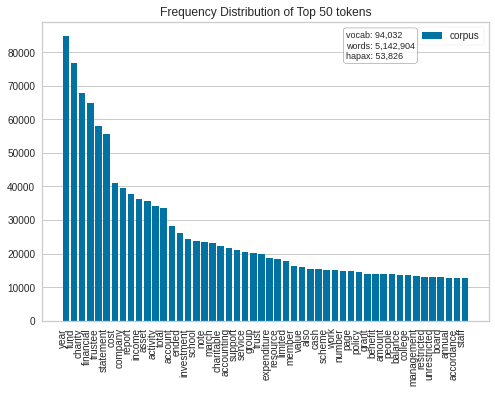

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [146]:
#Check the top words 

from sklearn.feature_extraction.text import CountVectorizer

from yellowbrick.text import FreqDistVisualizer
from yellowbrick.datasets import load_hobbies

# Load the text data
corpus = docs

#Intialise a count vectorizer
vectorizer = CountVectorizer()
#Get the count vectors for each doc
docs       = vectorizer.fit_transform(corpus)
#Get the features/words
features   = vectorizer.get_feature_names()
#Show the top features/words
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [15]:
'''
#Long way to Vectorize and Transform words to vectors

#instantiate CountVectorizer() 
cv=CountVectorizer() 
 
# this steps generates word counts for the words in your docs 
word_count_vector=cv.fit_transform(docs)

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)# print idf values 

df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)
'''

'#instantiate CountVectorizer() \ncv=CountVectorizer() \n \n# this steps generates word counts for the words in your docs \nword_count_vector=cv.fit_transform(docs)\n\ntfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) \ntfidf_transformer.fit(word_count_vector)# print idf values \n\ndf_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) \n \n# sort ascending \ndf_idf.sort_values(by=[\'idf_weights\'])\n\n# count matrix \ncount_vector=cv.transform(docs) \n \n# tf-idf scores \ntf_idf_vector=tfidf_transformer.transform(count_vector)\n\nfeature_names = cv.get_feature_names() \n \n#get tfidf vector for first document \nfirst_document_vector=tf_idf_vector[0] \n \n#print the scores \ndf = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) \ndf.sort_values(by=["tfidf"],ascending=False)\n'

In [74]:
'''
#Much shorter way to transform words to vectors

from sklearn.feature_extraction.text import TfidfVectorizer 
 
# settings that you use for count vectorizer will go here 
tfidf_vectorizer=TfidfVectorizer(use_idf=True, min_df=0.01) 
 
# just send in all your docs here 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)
'''

# Small TfidfVectorizer function

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfvec(docs):
    tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.8, max_features=200000,
                                 min_df=0.2,preprocessor=None, tokenizer=None)
    # just send in all your docs here
    fitted_vectorizer=tfidf_vectorizer.fit(docs)
    tfidf_vectorizer_vectors=fitted_vectorizer.transform(docs)
    X = tfidf_vectorizer_vectors
    print(tfidf_vectorizer_vectors.shape)
    return X

In [119]:
X = tfidfvec(docs)


(1729, 1010)


In [120]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.8, max_features=200000,
                                 min_df=0.2,preprocessor=None, tokenizer=None)
    # just send in all your docs here
fitted_vectorizer=tfidf_vectorizer.fit(docs)
tfidf_vectorizer_vectors=fitted_vectorizer.transform(docs)

In [122]:
print(dir(fitted_vectorizer))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_char_ngrams', '_char_wb_ngrams', '_check_n_features', '_check_params', '_check_stop_words_consistency', '_check_vocabulary', '_count_vocab', '_get_param_names', '_get_tags', '_limit_features', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_sort_features', '_stop_words_id', '_tfidf', '_validate_data', '_validate_params', '_validate_vocabulary', '_warn_for_unused_params', '_white_spaces', '_word_ngrams', 'analyzer', 'binary', 'build_analyzer', 'build_preprocessor', 'build_tokenizer', 'decode', 'decode_error', 'dtype', 'encoding', 'fit', 'fit_transform', 'fixed_vocabulary_', 'get_feature_name

In [126]:
#Show parameters of vectorizer
fitted_vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 200000,
 'min_df': 0.2,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [124]:
#Gets the vocabulary
fitted_vectorizer.vocabulary_

{'august': 104,
 'start': 887,
 'reference': 762,
 'administration': 33,
 'detail': 268,
 'name': 598,
 'known': 517,
 'principal': 699,
 'address': 30,
 'unit': 960,
 'business': 135,
 'park': 649,
 'road': 818,
 'manage': 562,
 'office': 621,
 'whole': 995,
 'person': 662,
 'body': 127,
 'entitled': 325,
 'appoint': 70,
 'chair': 150,
 'example': 348,
 'adviser': 41,
 'information': 487,
 'type': 954,
 'legal': 531,
 'john': 508,
 'north': 609,
 'solicitor': 872,
 'accountant': 9,
 'david': 240,
 'accountancy': 8,
 'chief': 159,
 'executive': 356,
 'senior': 843,
 'staff': 884,
 'structure': 901,
 'description': 265,
 'trust': 952,
 'governing': 425,
 'document': 292,
 'deed': 249,
 'constitution': 208,
 'constituted': 207,
 'association': 91,
 'company': 183,
 'incorporated': 479,
 'organisation': 633,
 'selection': 842,
 'method': 579,
 'appointed': 71,
 'elected': 307,
 'additional': 29,
 'issue': 504,
 'include': 473,
 'relevant': 779,
 'procedure': 705,
 'adopted': 36,
 'inducti

In [148]:
visualizer = FreqDistVisualizer(features=fitted_vectorizer.get_feature_names(), orient='v')
visualizer.fit(docs)
visualizer.show()

IndexError: list index out of range

In [43]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.8, max_features=200000,
                                 min_df=0)
fitted_vectorizer=tfidf_vectorizer.fit(docs)
tfidf_vectorizer_vectors=fitted_vectorizer.transform(docs)
tfidf.get_feature_names()

AttributeError: 'list' object has no attribute 'lower'

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer

# Load the data and create document vectors

tfidf = TfidfVectorizer()

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, km.labels_)
tsne.show()

NameError: name 'km' is not defined

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.datasets import load_hobbies
from yellowbrick.text import UMAPVisualizer

# Instantiate the text visualizer
umap = UMAPVisualizer()
umap.fit(X, km.labels)
umap.show()

YellowbrickValueError: umap package doesn't seem to be installed.Please install UMAP via: pip install umap-learn

In [22]:
dir(tsne)

['NULL_CLASS',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ax',
 '_check_n_features',
 '_fig',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_size',
 '_validate_data',
 'alpha',
 'ax',
 'classes_',
 'color',
 'color_values_',
 'colormap',
 'colors',
 'draw',
 'fig',
 'finalize',
 'fit',
 'fit_transform',
 'fit_transform_show',
 'get_params',
 'labels',
 'make_transformer',
 'n_instances_',
 'poof',
 'random_state',
 'set_params',
 'set_title',
 'show',
 'size',
 'title',
 'transform',
 'transformer_']

In [137]:
X[1709]

<1x10408 sparse matrix of type '<class 'numpy.float64'>'
	with 1459 stored elements in Compressed Sparse Row format>

# Calculate the pairwise similarity matrix

pairwise_similarity = X * X.T 

In [117]:
pairwise_similarity[1]

<1x1729 sparse matrix of type '<class 'numpy.float64'>'
	with 1729 stored elements in Compressed Sparse Row format>

In [112]:
density = X.getnnz() / np.prod(X.shape)
density

0.1002656674204876

# Plot the sparse matrix of Tfifd scores

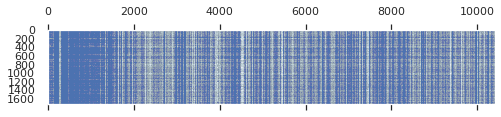

In [143]:
plt.spy(X, markersize=0.1)

In [121]:
A = sparse.random(100,100, density=0.01)
plt.spy(A, markersize=4)

NameError: name 'sparse' is not defined

In [139]:
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    ax.plot(m.col, m.row, 's', color='white', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

In [108]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(pairwise_similarity)

ValueError: Must pass 2-d input. shape=()

In [29]:
#experient with changing paramters in tfidf

min_df = [0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.12,0.14,0.16, 0.18, 0.2]
max_df = 

result=[]
for i in min_df:
    tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.8, max_features=200000,
                                 min_df=i)
    # just send in all your docs here
    fitted_vectorizer=tfidf_vectorizer.fit(docs)
    tfidf_vectorizer_vectors=fitted_vectorizer.transform(docs)
    shape = tfidf_vectorizer_vectors.shape
    print(i, shape)


0 (1729, 144539)
0.01 (1729, 10408)
0.02 (1729, 7323)
0.03 (1729, 5945)
0.04 (1729, 5098)
0.05 (1729, 4581)
0.06 (1729, 4191)
0.07 (1729, 3899)
0.08 (1729, 3661)
0.09 (1729, 3432)
0.1 (1729, 3247)
0.12 (1729, 2926)
0.14 (1729, 2364)
0.16 (1729, 1939)
0.18 (1729, 1656)
0.2 (1729, 1450)


# HashingVectorizer

In [114]:
from sklearn.feature_extraction.text import HashingVectorizer

hashvectorizer = HashingVectorizer(encoding='utf-8',
                    decode_error='strict', strip_accents=None,
                    lowercase=False, preprocessor=None,
                    tokenizer=None, stop_words=None,
                    token_pattern='(?u)\b\w\w+\b',
                    ngram_range=(1, 1), analyzer='word',
                    n_features=10000, binary=False,
                    norm='l2', alternate_sign=True,)


In [115]:
fitted_vectorizer=hashvectorizer.fit(docs)
#hash_vectorizer_vectors=fitted_vectorizer.transform(docs)

In [116]:
hashvec = fitted_vectorizer.transform(docs)

In [117]:
hashvec

<1729x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [110]:
docs = docs.astype('string')
docs.dtypes

StringDtype

In [113]:
docs

0       ['august', 'trustee', 'annual', 'report', 'per...
1       ['receipt', 'payment', 'account', 'period', 's...
2       ['welcome', 'annual', 'report', 'first', 'time...
3       ['annual', 'repor', 'account', 'year', 'ended'...
4       ['greenway', 'centre', 'registered', 'charity'...
                              ...                        
1724    ['august', 'trustee', 'annual', 'report', 'per...
1725    ['gordon', 'russell', 'trust', 'charity', 'tru...
1726    ['charity', 'period', 'start', 'date', 'period...
1727    ['caspari', 'foundation', 'company', 'number',...
1728    ['registered', 'company', 'number', 'england',...
Name: preprocess, Length: 1729, dtype: string

In [86]:
kcluster(hashvectorizer)

Clustering sparse data with KMeans(max_iter=1000, n_clusters=10)


TypeError: float() argument must be a string or a number, not 'HashingVectorizer'

In [85]:
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
import sys
from time import time

def kcluster(X):
    #Initialize
    km = KMeans(n_clusters=10, init='k-means++', max_iter=1000, n_init=10,
                verbose=0)
    
    print("Clustering sparse data with %s" % km)
    t0 = time()
    
    km.fit(X)
    km.predict(X)
    X_trans = km.transform(X)
    
    #Verbose info
    print("done in %0.3fs" % (time() - t0))
    
    #Clustering metric
    print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))
    
    #Plot
    plt.scatter(X_trans[:, 0], X_trans[:, 1], c=km.labels_, s=20, cmap='viridis')
    #cmaps['viridis', 'plasma', 'inferno', 'magma', 'cividis']

Clustering sparse data with KMeans(max_iter=1000, n_clusters=10)
done in 7.200s
Silhouette Coefficient: 0.040


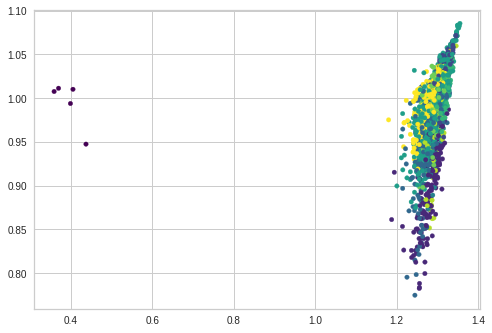

In [66]:
#Run clustering
kcluster(X)

ValueError: setting an array element with a sequence.

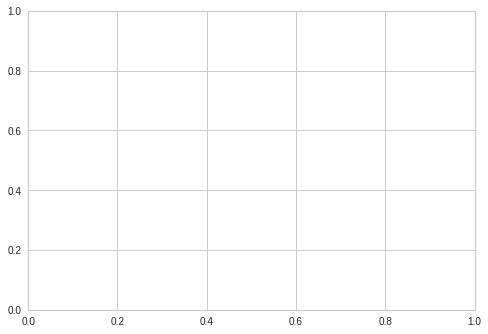

In [60]:
import matplotlib.pyplot as plt
plt.scatter(X,X, s=20, cmap='viridis')

/home/becode/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/becode/.local/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/becode/.local/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


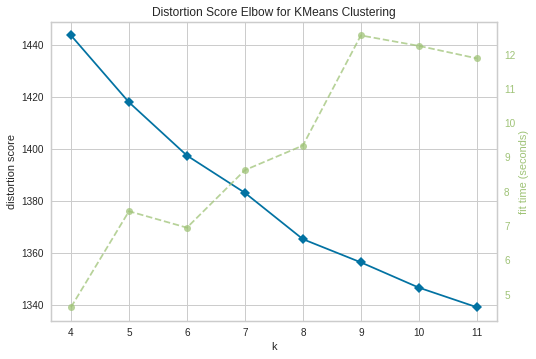

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [81]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [46]:
X_new = km.fit_transform(X)

Initialization complete
Iteration 0, inertia 2397.967268864254
Iteration 1, inertia 1367.9648762668467
Iteration 2, inertia 1357.7719532330855
Iteration 3, inertia 1355.1893712113208
Iteration 4, inertia 1354.3188541645748
Iteration 5, inertia 1354.0479706525748
Iteration 6, inertia 1353.880105489739
Iteration 7, inertia 1353.6428203435084
Iteration 8, inertia 1353.578016165946
Iteration 9, inertia 1353.5472577831383
Iteration 10, inertia 1353.5215939766656
Iteration 11, inertia 1353.5160913295324
Iteration 12, inertia 1353.5031453984889
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 2524.9756820109546
Iteration 1, inertia 1400.106264038081
Iteration 2, inertia 1374.7563163089528
Iteration 3, inertia 1358.8950227831529
Iteration 4, inertia 1353.3805010822662
Iteration 5, inertia 1350.9375039672502
Iteration 6, inertia 1349.8121422768638
Iteration 7, inertia 1349.3401287564618
Iteration 8, inertia 1349.1139896092873
Iteration 9, inertia 1348.

Iteration 18, inertia 1359.7953322622843
Iteration 19, inertia 1359.769240369313
Iteration 20, inertia 1359.7463073493866
Iteration 21, inertia 1359.718371191989
Iteration 22, inertia 1359.7109817999055
Iteration 23, inertia 1359.7031014745999
Iteration 24, inertia 1359.695911629404
Converged at iteration 24: strict convergence.
Initialization complete
Iteration 0, inertia 2480.3927915659588
Iteration 1, inertia 1382.5969010316348
Iteration 2, inertia 1369.0246189139784
Iteration 3, inertia 1363.5856948012288
Iteration 4, inertia 1360.8279391466822
Iteration 5, inertia 1359.5006325904728
Iteration 6, inertia 1358.4893858935334
Iteration 7, inertia 1357.5886640374524
Iteration 8, inertia 1356.691487021494
Iteration 9, inertia 1356.135345199088
Iteration 10, inertia 1355.898936707259
Iteration 11, inertia 1355.7916473756782
Iteration 12, inertia 1355.6966291591832
Iteration 13, inertia 1355.6001051626454
Iteration 14, inertia 1355.5207528536423
Iteration 15, inertia 1355.409579214319
Ite

In [48]:
y_kmeans = km.predict(X)

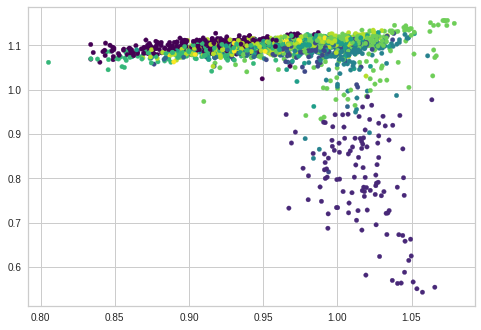

In [56]:
X_new = km.fit_transform(X)
import matplotlib.pyplot as plt
plt.scatter(X_new[:, 0], X_new[:, 1], c=km.labels_, s=20, cmap='viridis')
#cmaps['Perceptually Uniform Sequential'] = [
#            'viridis', 'plasma', 'inferno', 'magma', 'cividis']

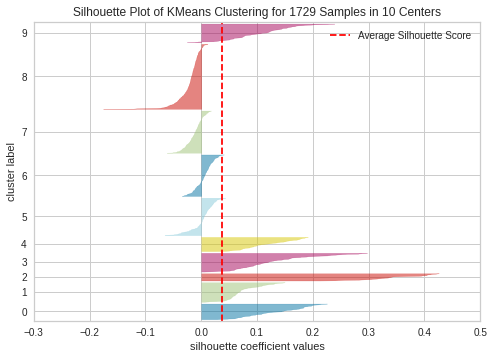

/home/becode/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1729 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick', model=None)

In [95]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.datasets import load_credit

# Use the quick method and immediately show the figure
silhouette_visualizer(km, X, colors='yellowbrick')

In [102]:
import sklearn.preprocessing as pp

def cosine_similarities(X):
    #X_norm = pp.normalize(X.tocsc(), axis=0)
    return X.T * X

In [103]:
X_cos = cosine_similarities(X)

In [101]:
type(X_cos)

scipy.sparse.csr.csr_matrix

In [38]:
len(labels)
labels.fillna('Nonumber', inplace=True)
labels.isna().sum()

0

In [33]:
len(km.labels_)

1729

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

X = cosine_similarity(tfidf_vectorizer_vectors)



<class 'numpy.ndarray'>


In [26]:
tfidf_vectorizer_vectors.shape


(1729, 7323)

In [27]:
X.shape

(1729, 1729)

In [28]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5, metric='cosine')
cos = neigh.fit(tfidf_vectorizer_vectors)

In [31]:
cos

NearestNeighbors(metric='cosine')

In [ ]:
def max_n(row_data, row_indices, n):
        i = row_data.argsort()[-n:]
        # i = row_data.argpartition(-n)[-n:]
        top_values = row_data[i]
        top_indices = row_indices[i]  # do the sparse indices matter?

        return top_values, top_indices, i

In [ ]:
# Create a tool and make it public

In [91]:
from pyclustering.cluster.dbscan import dbscan
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES
# Sample for cluster analysis.
#sample = read_sample(FCPS_SAMPLES.SAMPLE_CHAINLINK)
# Create DBSCAN algorithm.
dbscan_instance = dbscan(X, 0.2, 10)
# Start processing by DBSCAN.
dbscan_instance.process()
# Obtain results of clustering.
clusters = dbscan_instance.get_clusters()
noise = dbscan_instance.get_noise()
# Visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, X)
visualizer.append_cluster(noise, X, marker='x')
visualizer.show()

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [150]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN()
clusters = dbscan.fit_predict(X)
print("Cluster memberships:\n{}".format(clusters))

Cluster memberships:
[-1 -1 -1 ... -1 -1 -1]


ValueError: 'c' argument has 1729 elements, which is inconsistent with 'x' and 'y' with size 1.

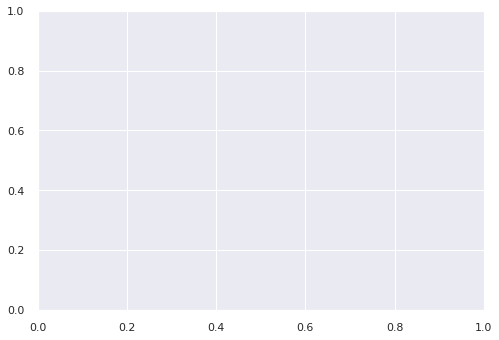

In [155]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = .5, min_samples = 5)

clusters = dbscan.fit_predict(X)
# plot the cluster assignments
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap=mglearn.cm2, s=60)

In [158]:
X[0,:]

<1x10408 sparse matrix of type '<class 'numpy.float64'>'
	with 429 stored elements in Compressed Sparse Row format>

In [ ]:
X_fit

In [148]:
dir(X_fit)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__

In [57]:
docs

0       TAR 1 August 2016 Trustees' Annual Report for ...
1        ; Na {if anv) { oA el C 3 QIC [1€d C f (S ' R...
2       54 S ke * B   Welcome to our Annual Report for...
3       Annual Repor t 8 Accounts 2017/18 Year ended 3...
4       The Greenway Centre (Registered charity, numbe...
                              ...                        
1724    TAR 1 August 2016 Trustees' Annual Report for ...
1725    The Gordon Russell Trust Charity No. 326446 Tr...
1726    Charity No (if any) 1111593 Period start date ...
1727    CASPARI FOUNDATION (Company Number 3815700) (R...
1728    REGISTERED COMPANY NUMBER: 09623674 (England a...
Name: text, Length: 1729, dtype: object